# **Installing packages**

In [ ]:
!git clone https://github.com/CAMeL-Lab/camel_tools.git
%cd camel_tools
!pip install .
!pip install gensim
!camel_data -i all

Cloning into 'camel_tools'...
remote: Enumerating objects: 3292, done.
remote: Counting objects: 100% (384/384), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 3292 (delta 339), reused 294 (delta 293), pack-reused 2908 (from 1)
Receiving objects: 100% (3292/3292), 11.77 MiB | 21.38 MiB/s, done.
Resolving deltas: 100% (2249/2249), done.
/content/camel_tools
Processing /content/camel_tools
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 556.4/556.4 kB 18.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
pip install nltk


In [ ]:
pip install moviepy

# **Import necessary libraries**

In [ ]:
# Import necessary libraries

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Text processing and normalization
from gensim.models import Word2Vec
from camel_tools.utils.dediac import dediac_ar
from camel_tools.utils.normalize import normalize_alef_maksura_ar, normalize_teh_marbuta_ar, normalize_alef_ar

# Machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Video processing

from moviepy.editor import VideoFileClip, concatenate_videoclips
from IPython.display import Video, display

# Similarity measurement
from difflib import SequenceMatcher

# Google Drive module from Google Colab
from google.colab import drive


  if event.key is 'enter':



# **Dataset loading**

In [ ]:
# Load the CSV file
df = pd.read_csv('/content/datanew2.csv')

# Inspect the first few rows of the dataset
print(df.head())

  Arabic text ARSL Translation
0        وردي         وردي.mp4
1         هرم          هرم.mp4
2        نجمة         نجمة.mp4
3      منشوري       منشوري.mp4
4      حلزوني       حلزوني.mp4


In [ ]:
# print the number of to check duplicated values
df.duplicated().sum()

390

In [ ]:
# removing the duplicated values
index = df[df['Arabic text'].duplicated() == True].index
df.drop(index, axis = 0, inplace = True)

# print the number to see the duplicated values after removing it
df.duplicated().sum()

0

 # **Dataset and Text preprocessing**

In [ ]:
# Define the normalize_arabic function
def normalize_arabic(text):
    # Normalize Alef, Alef Maksura, and Teh Marbuta variations
    text = normalize_alef_ar(text)
    text = normalize_alef_maksura_ar(text)
    text = normalize_teh_marbuta_ar(text)
    # Remove Arabic diacritics (Tashkeel السَّلَامُ)
    text = dediac_ar(text)
    # Simplify elongated Arabic letters
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('ييي', 'ي')
    text = text.replace('اا', 'ا')
    # remove extra whitespace
    text = re.sub('\s+', ' ', text)
    # Remove longation " السلااااام"
    text = re.sub(r'(.)\1+', r"\1\1", text)
    return text

# Define a function to clean the text
def clean_text(text):
    if not isinstance(text, str):
        return ''  # If the input is not a string (Number or None), return an empty.
    # Normalize Arabic text
    text = normalize_arabic(text)
    # Remove question marks
    text = re.sub(r'\؟', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove extra spaces
    text = text.strip()
    return text

# Apply the cleaning function to your dataset's text column
df['Cleaned Text'] = df['Arabic text'].apply(clean_text)

# Display the cleaned text column
print(df['Cleaned Text'])

0                   وردي
1                    هرم
2                   نجمه
3                 منشوري
4                 حلزوني
              ...       
7216    لون بخور امي بني
7217       لون القمح بني
7218      لون الضوء اصفر
7219           وره صفراء
7220      لون الورد اصفر
Name: Cleaned Text, Length: 6739, dtype: object


In [ ]:
# Tokenize the cleaned text
df['Tokenized Text'] = df['Cleaned Text'].apply(lambda x: x.split())

# print
print(df[['Cleaned Text', 'Tokenized Text']].head())
df.tail()

  Cleaned Text Tokenized Text
0         وردي         [وردي]
1          هرم          [هرم]
2         نجمه         [نجمه]
3       منشوري       [منشوري]
4       حلزوني       [حلزوني]


Arabic text ARSL Translation      Cleaned Text  \
7216  لون بخور أمي بني          بني.mp4  لون بخور امي بني   
7217     لون القمح بني          بني.mp4     لون القمح بني   
7218    لون الضوء أصفر         أصفر.mp4    لون الضوء اصفر   
7219        ورة صفراء          أصفر.mp4         وره صفراء   
7220    لون الورد أصفر         أصفر.mp4    لون الورد اصفر   

             Tokenized Text  
7216  [لون, بخور, امي, بني]  
7217      [لون, القمح, بني]  
7218     [لون, الضوء, اصفر]  
7219           [وره, صفراء]  
7220     [لون, الورد, اصفر]

# **Word2Vec Embedding**

In [ ]:
# Training Word2Vec model on tokenized text
# Convert 'Tokenized Text' column to a list of sentences (each sentence is a list of words)
sentences = df['Tokenized Text'].tolist()

# Train the Word2Vec model with the given parameters: vector size, context window, minimum word count, and worker threads
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)


# This function takes a sentence and generates an average embedding using the Word2Vec model
def get_sentence_embedding(sentence, model, vector_size=100):
    sentence_embedding = np.zeros(vector_size)  # Initialize an embedding vector with all zeros
    word_count = 0  # To keep track of the number of valid words

    # Iterate over each word in the sentence
    for word in sentence.split():
        if word in model.wv:  # Check if the word is in the Word2Vec vocabulary
            sentence_embedding += model.wv[word]  # Add the word vector to the sentence embedding
            word_count += 1  # Increment the word count

    # If there are any valid words, calculate the average embedding
    if word_count > 0:
        sentence_embedding /= word_count

    return sentence_embedding  # Return final averaged embedding


# Apply the function to generate an embedding for each sentence in the 'Cleaned Text' column
df['Embedding'] = df['Cleaned Text'].apply(lambda x: get_sentence_embedding(x, word2vec_model))

# Print
print(df[['Cleaned Text', 'Embedding']].head())
df.tail()


  Cleaned Text                                          Embedding
0         وردي  [-0.0018011737847700715, 0.006811213679611683,...
1          هرم  [0.007084892131388187, 0.004544110037386417, -...
2         نجمه  [-0.009328368119895458, -0.009421377442777157,...
3       منشوري  [0.003898750524967909, 0.0031338620465248823, ...
4       حلزوني  [-0.005757023114711046, 0.0039318520575761795,...


Arabic text ARSL Translation      Cleaned Text  \
7216  لون بخور أمي بني          بني.mp4  لون بخور امي بني   
7217     لون القمح بني          بني.mp4     لون القمح بني   
7218    لون الضوء أصفر         أصفر.mp4    لون الضوء اصفر   
7219        ورة صفراء          أصفر.mp4         وره صفراء   
7220    لون الورد أصفر         أصفر.mp4    لون الورد اصفر   

             Tokenized Text                                          Embedding  
7216  [لون, بخور, امي, بني]  [-0.00772463355679065, 0.0016887770616449416, ...  
7217      [لون, القمح, بني]  [-0.007847925492872795, 0.0022811093367636204,...  
7218     [لون, الضوء, اصفر]  [0.0002637958774964015, 0.0028798342682421207,...  
7219           [وره, صفراء]  [-0.004036618745885789, 0.003641784831415862, ...  
7220     [لون, الورد, اصفر]  [-0.004026145053406556, 0.006684189196676016, ...

# **KNN**


In [ ]:
# prepare data for the model
x_k = np.array(df['Embedding'].tolist())  # Features (embeddings)
y_k = df['ARSL Translation']  # Labels (video paths)

# Split the data into train and test sets
x_train_k, x_test_k, y_train_k, y_test_k = train_test_split(x_k, y_k, test_size=0.2, random_state=42)

In [ ]:
# training part

# Initialize the KNN classifier
knn_model = KNeighborsClassifier(n_neighbors=1)

# Train the model
knn_model.fit(x_train_k, y_train_k)

# Predict on the test set
y_pred_k = knn_model.predict(x_test_k)

In [ ]:
# Find the optimal value of k that maximizes accuracy.
# Define the range of k values
param_grid = {'n_neighbors': [1, 3, 5, 7, 9, 11, 15, 19, 23]}

"""  Perform a Grid Search Cross Validation (GridSearchCV) to find the best k value.
     The GridSearchCV will evaluate the KNeighborsClassifier with each k value
"""

# Perform GridSearch to find the best k
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
# Fit the GridSearchCV model to the training data
grid_search.fit(x_train_k, y_train_k)
# Print the best k value and highest accuracy.
print(f"Best K: {grid_search.best_params_['n_neighbors']}")
print(f"Best Accuracy: {grid_search.best_score_ * 100:.2f}%")



  warnings.warn(



Best K: 1
Best Accuracy: 23.33%


In [ ]:
# Evaluating the model

""" Calculate and print performance metrics for the model's predictions.
    'weighted' averages metrics considering class sizes, giving more weight
     to larger classes (useful for imbalanced datasets) """

accuracy = accuracy_score(y_test_k, y_pred_k)
precision = precision_score(y_test_k, y_pred_k, average='weighted')
recall = recall_score(y_test_k, y_pred_k, average='weighted')
f1 = f1_score(y_test_k, y_pred_k, average='weighted')

# display the results
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Accuracy: 23.44%
Precision: 21.65%
Recall: 23.44%
F1 Score: 20.25%


# **KNN Predictions**

In [ ]:
# Mount the Google Drive to the Colab environment
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
# Function to get the corresponding video based on the predicted class
def get_corresponding_video(predicted_class):
    # Convert numpy array to string (extract the predicted class)
    predicted_class = predicted_class[0]  # Convert numpy array to a single string

    # Path to the video folder in Google Drive
    video_folder = '/content/drive/MyDrive/SeniorProject_2/videos'

    # Clean up the predicted class and ensure .mp4 is appended only once
    if not predicted_class.endswith('.mp4'):
        predicted_class = f"{predicted_class}.mp4"

    video_path = os.path.join(video_folder, predicted_class)

    # Print the predicted class and video path
    print(f"Predicted Class: '{predicted_class}'")
    print(f"Video Path: '{video_path}'")

    # Check if the video file exists in Google Drive
    if os.path.exists(video_path):
        return video_path
    else:
        print(f"MP4 for '{predicted_class}' not found.")
        return None


In [ ]:
# Extract all unique phrases from the "Arabic text" column
dataset_phrases = df['Arabic text'].unique().tolist()

# Function to clean user input by removing non-Arabic characters, digits
def clean_user_input(text):
    # Sort phrases by length to match longer phrases first (to capture multi-word phrases first)
    sorted_phrases = sorted(dataset_phrases, key=len, reverse=True)
    # Remove English letters
    text = re.sub('[A-Za-z]+', ' ', text)
    # Remove digits
    text = ''.join([i for i in text if not i.isdigit()])
    # Apply additional text normalization and cleaning
    text = clean_text(text)
    # Print cleaned text
    print("Cleaned Text:", text)

    # Replace each phrase in the text with a unique marker if it exists in the dataset
    for phrase in sorted_phrases:
        if phrase in text:
            text = text.replace(phrase, phrase.replace(" ", "_"))

    # Split the cleaned text into tokens
    tokens = text.split()

    # Replace markers back to original phrases
    tokens = [token.replace("_", " ") for token in tokens]

    # Print tokenized text
    print("Tokenized Text:", tokens)

    return tokens

# Function to measure similarity between two strings
def similarity_ratio(a, b):
    return SequenceMatcher(None, a, b).ratio()

# Function to preprocess and predict using the model for each token
def preprocess_and_predict(user_input):
    # Clean and tokenize the input text
    tokenized_user_input = clean_user_input(user_input)

    # Initialize a list for all video paths
    video_paths = []

    # Iterate through each token, feed it to the model, and predict the video path
    for token in tokenized_user_input:
        print(f"\nFeeding token '{token}' to the KNN model...")
        user_embedding = get_sentence_embedding(token, word2vec_model).reshape(1, -1)
        predicted_class = knn_model.predict(user_embedding)[0]  # Get the predicted class as a single string

        # Remove the .mp4 suffix from the predicted class for comparison
        predicted_class_without_extension = predicted_class.replace('.mp4', '')

        # Calculate the similarity between the token and predicted class (without .mp4)
        similarity = similarity_ratio(token, predicted_class_without_extension)
        print(f"Predicted class for '{token}': '{predicted_class}' (Similarity: {similarity * 100:.2f}%)")

        # Check if similarity is above 50%
        if similarity >= 0.50:
            # High similarity, fetch the video directly
            video_path = get_corresponding_video([predicted_class])
            video_paths.append(video_path)
            print(f"Direct match (50%+ similarity) found for token '{token}'. Playing video: {video_path}")
        else:
            # Low similarity, apply fingerspelling
            print(f"Low similarity for token '{token}' (Similarity: {similarity * 100:.2f}%). Applying fingerspelling.")
            for char in token:
                char_video_path = get_corresponding_video([char])
                if char_video_path:
                    video_paths.append(char_video_path)
                    print(f"Playing fingerspell video for '{char}': {char_video_path}")
                else:
                    print(f"No video found for character '{char}' in dataset.")

    return video_paths

# Take input from the user
user_input = input("Enter Arabic text: ")
video_paths = preprocess_and_predict(user_input)

In [ ]:

def combine_videos(video_paths, output_path="combined_output.mp4"):
    """
    Combine all videos in the list of video_paths into one video.
    """
    clips = []
    for video_path in video_paths:
        if os.path.exists(video_path):
            try:
                clips.append(VideoFileClip(video_path))
            except Exception as e:
                print(f"Error loading video {video_path}: {e}")
    if clips:
        # Combine the video clips
        final_clip = concatenate_videoclips(clips, method="compose")
        # Write the combined video to a file
        final_clip.write_videofile(output_path, codec="libx264", audio_codec="aac")
        print(f"Combined video saved as {output_path}")
        return output_path
    else:
        print("No valid videos to combine.")
        return None

# Use video_paths from the previous output
# Make sure the variable `video_paths` is already defined in a previous cell
if 'video_paths' in locals() or 'video_paths' in globals():
    # Combine all videos into one
    output_video_path = "combined_output.mp4"
    combined_video = combine_videos(video_paths, output_path=output_video_path)

    # Display the combined video
    if combined_video:
        display(Video(combined_video, embed=True, width=800, height=600))
else:
    print("Error: 'video_paths' variable is not defined. Please run the previous cell to generate it.")


# **KNN Measurements**

  warnings.warn(



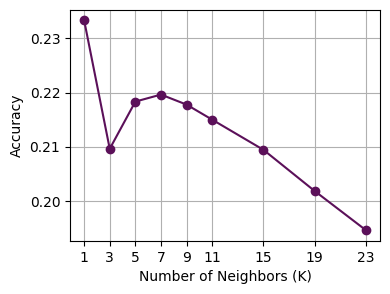

In [ ]:
"""
     Extract results for plotting
     By Retrieving k values and corresponding
     mean test accuracies from GridSearchCV results.
     Plot k values (x-axis) against accuracy (y-axis)
     using a line plot with markers.
"""

k_values = param_grid['n_neighbors']
accuracies = grid_search.cv_results_['mean_test_score']

# Plot Accuracy vs. K Values
plt.figure(figsize=(4, 3))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='#5b1059')
plt.title('Accuracy vs. K Values in KNN')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid()
plt.show()


# **SVM**

In [ ]:
# prepare data for the model
X = np.array(df['Embedding'].tolist())  # Features (embeddings)
y = df['ARSL Translation']  # Labels

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Initialize the SVM model

# Initialize the SVM model with RBF kernel and custom C and gamma
svm_model = SVC(kernel='rbf', C=10, gamma="scale", random_state=42)

# Train the SVM model
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test)

In [ ]:
# Evaluating the model

"""  Perform a Grid Search Cross Validation (GridSearchCV) to find the best k value.
     The GridSearchCV will evaluate the KNeighborsClassifier with each k value
"""

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the results
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Accuracy: 26.63%
Precision: 28.19%
Recall: 26.63%
F1 Score: 24.85%


# **SVM Predictions**

In [ ]:
# Function to get the corresponding video based on the predicted class
def get_corresponding_video(predicted_class):
    # Convert numpy array to string (extract the predicted class)
    predicted_class = predicted_class[0]  # Convert numpy array to a single string

    # Path to the video folder in Google Drive
    video_folder = '/content/drive/MyDrive/SeniorProject_2/videos'

    # Clean up the predicted class and ensure .mp4 is appended only once
    if not predicted_class.endswith('.mp4'):
        predicted_class = f"{predicted_class}.mp4"

    video_path = os.path.join(video_folder, predicted_class)

    # Debugging: Print the predicted class and video path
    print(f"Predicted Class: '{predicted_class}'")
    print(f"Video Path: '{video_path}'")

    # Check if the video file exists in Google Drive
    if os.path.exists(video_path):
        return video_path
    else:
        print(f"MP4 for '{predicted_class}' not found.")
        return None


In [ ]:
# Extract all unique phrases from the "Arabic text" column
dataset_phrases = df['Arabic text'].unique().tolist()

# Function to clean user input by removing non-Arabic characters, digits
def clean_user_input(text):
    # Sort phrases by length to match longer phrases first (to capture multi-word phrases first)
    sorted_phrases = sorted(dataset_phrases, key=len, reverse=True)
    # Remove English letters
    text = re.sub('[A-Za-z]+', ' ', text)
    # Remove digits
    text = ''.join([i for i in text if not i.isdigit()])
    # Apply additional text normalization and cleaning
    text = clean_text(text)
    # Print the cleaned text
    print("Cleaned Text:", text)

    # Replace each phrase in the text with a unique marker if it exists in the dataset
    for phrase in sorted_phrases:
        if phrase in text:
            text = text.replace(phrase, phrase.replace(" ", "_"))

    # Split the cleaned text into tokens
    tokens = text.split()

    # Replace markers back to original phrases
    tokens = [token.replace("_", " ") for token in tokens]

    # Print tokenized text
    print("Tokenized Text:", tokens)

    return tokens

# Function to measure similarity between two strings
def similarity_ratio(a, b):
    return SequenceMatcher(None, a, b).ratio()

# Function to preprocess and predict using the model for each token
def preprocess_and_predict(user_input):
    # Clean and tokenize the input text
    tokenized_user_input = clean_user_input(user_input)

    # Initialize a list for all video paths
    video_paths = []

    # Iterate through each token, feed it to the model, and predict the video path
    for token in tokenized_user_input:
        print(f"\nFeeding token '{token}' to the SVM model...")
        user_embedding = get_sentence_embedding(token, word2vec_model).reshape(1, -1)
        predicted_class = svm_model.predict(user_embedding)[0]  # Get the predicted class as a single string

        # Remove the .mp4 suffix from the predicted class for comparison
        predicted_class_without_extension = predicted_class.replace('.mp4', '')

        # Calculate the similarity between the token and predicted class (without .mp4)
        similarity = similarity_ratio(token, predicted_class_without_extension)
        print(f"Predicted class for '{token}': '{predicted_class}' (Similarity: {similarity * 100:.2f}%)")

        # Check if similarity is above 50%
        if similarity >= 0.50:
            # High similarity, fetch the video directly
            video_path = get_corresponding_video([predicted_class])
            video_paths.append(video_path)
            print(f"Direct match (50%+ similarity) found for token '{token}'. Playing video: {video_path}")
        else:
            # Low similarity, apply fingerspelling
            print(f"Low similarity for token '{token}' (Similarity: {similarity * 100:.2f}%). Applying fingerspelling.")
            for char in token:
                char_video_path = get_corresponding_video([char])
                if char_video_path:
                    video_paths.append(char_video_path)
                    print(f"Playing fingerspell video for '{char}': {char_video_path}")
                else:
                    print(f"No video found for character '{char}' in dataset.")

    return video_paths

# Take input from the user
user_input = input("Enter Arabic text: ")
video_paths = preprocess_and_predict(user_input)

Enter Arabic text: توبة صلاة
Cleaned Text: توبه صلاه
Tokenized Text: ['توبه', 'صلاه']

Feeding token 'توبه' to the SVM model...
Predicted class for 'توبه': 'التوبة.mp4' (Similarity: 60.00%)
Predicted Class: 'التوبة.mp4'
Video Path: '/content/drive/MyDrive/SeniorProject_2/videos/التوبة.mp4'
Direct match (50%+ similarity) found for token 'توبه'. Playing video: /content/drive/MyDrive/SeniorProject_2/videos/التوبة.mp4

Feeding token 'صلاه' to the SVM model...
Predicted class for 'صلاه': 'وقت.mp4' (Similarity: 0.00%)
Low similarity for token 'صلاه' (Similarity: 0.00%). Applying fingerspelling.
Predicted Class: 'ص.mp4'
Video Path: '/content/drive/MyDrive/SeniorProject_2/videos/ص.mp4'
Playing fingerspell video for 'ص': /content/drive/MyDrive/SeniorProject_2/videos/ص.mp4
Predicted Class: 'ل.mp4'
Video Path: '/content/drive/MyDrive/SeniorProject_2/videos/ل.mp4'
Playing fingerspell video for 'ل': /content/drive/MyDrive/SeniorProject_2/videos/ل.mp4
Predicted Class: 'ا.mp4'
Video Path: '/content/d

Playing video: /content/drive/MyDrive/SeniorProject_2/videos/ص.mp4


Playing video: /content/drive/MyDrive/SeniorProject_2/videos/ل.mp4


Playing video: /content/drive/MyDrive/SeniorProject_2/videos/ا.mp4


Playing video: /content/drive/MyDrive/SeniorProject_2/videos/ه.mp4


In [ ]:
def combine_videos(video_paths, output_path="combined_output.mp4"):
    """
    Combine all videos in the list of video_paths into one video.
    """
    clips = []
    for video_path in video_paths:
        if os.path.exists(video_path):
            try:
                clips.append(VideoFileClip(video_path))
            except Exception as e:
                print(f"Error loading video {video_path}: {e}")
    if clips:
        # Combine the video clips
        final_clip = concatenate_videoclips(clips, method="compose")
        # Write the combined video to a file
        final_clip.write_videofile(output_path, codec="libx264", audio_codec="aac")
        print(f"Combined video saved as {output_path}")
        return output_path
    else:
        print("No valid videos to combine.")
        return None

# Use video_paths from the previous output
# Make sure the variable `video_paths` is already defined in a previous cell
if 'video_paths' in locals() or 'video_paths' in globals():
    # Combine all videos into one
    output_video_path = "combined_output.mp4"
    combined_video = combine_videos(video_paths, output_path=output_video_path)

    # Display the combined video
    if combined_video:
        display(Video(combined_video, embed=True, width=800, height=600))
else:
    print("Error: 'video_paths' variable is not defined. Please run the previous cell to generate it.")


Moviepy - Building video combined_output.mp4.
Moviepy - Writing video combined_output.mp4



Moviepy - Done !
Moviepy - video ready combined_output.mp4
Combined video saved as combined_output.mp4
